In [54]:
import pandas as pd
import seaborn as sb
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

In [2]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

test_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


# Plan
1. empty values/NaNs  - we can think about imputation or smarter way to drop samples
2. check for outliers
3. see distributions for features
4. remove features that has small variability   - 
5. mapping classes into numeric values
6. look into feature correlation

**1**

In [81]:
def clean_df(df):
    columns_with_na = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond" , "PoolQC", "Fence"]
    s,f = df.shape
    for col in columns_with_na:
        df[col] = df[col].fillna(0)
    

    #object col to numerical (so we can analyze the data dist and detect outliers). I also printed all the 
    # uniques values. The main "issue" is the we ifnore from context in this transformation- in case of 
    # values like:
#        Ex	Excellent
#        Gd	Good
#        TA	Average/Typical
#        Fa	Fair
#        Po	Poor
    for col in df.columns:
        if (df[col].dtype == object) :
            df[col], uniques = pd.factorize(df[col])  #nan values will be marked as -1. 
#             print(f"{col} values:", uniques) 
    
    # fillna with mean col value
    df= df.fillna(df.mean())

    print(df.shape, "before zscore")
    # remove outliers by there Z-score (example" LotArea column)
    # The recommended threshold is 3, but it cuased a big number of drops so I increased it to 5 
    df= df[(np.abs(zscore(df)) < 5).all(axis=1)]
    print(df.shape, "after zscore")
    
    #detect columns with high precantage from one value
    percentage= 0.99
    for col in df.columns:
        count= df[col].value_counts(normalize=True).values
        if sum(count>percentage):
            print(col)
            
    return df

    #     print("# of samples were dropped:", s-df.dropna().shape[0],np.round(100*(s-df.dropna().shape[0])/s,2), "% of the samples")

In [83]:
def data_dist(df):
    n_col = 6
    n_row = np.ceil(df.shape[1]/n_col)
    fig = plt.figure(figsize=(3 * n_col, 2.4 * n_row))  
    for i, col in enumerate(df.columns):
        plt.subplot(n_row, n_col, i + 1)
        n, bins, patches= plt.hist(df[col], density=True)
        plt.title(col, y=1.03)
    fig.tight_layout(pad=2)

In [27]:
# test_data.isna().sum() > 0
# test_data.columns[test_data.isna().sum() > 0]
# [a for a in zip(test_data.columns, test_data.isnull().sum().tolist())]

# test_data = test_data.replace(np.nan, 'Data N/A')

# [a for a in zip(test_data.columns, test_data.isnull().sum().tolist())]
# test_data[test_data.LotFrontage.isna()]

# test_data.PoolQC.map({ np.nan: 0 })
    
# [a for a in zip(test_data.columns, test_data.isnull().sum().tolist())]

# test_data.PoolQC

(1460, 78) before zscore
(1233, 78) after zscore
Street
Utilities
Condition2
RoofMatl
Heating
LowQualFinSF
3SsnPorch
PoolArea
PoolQC


<ipython-input-83-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


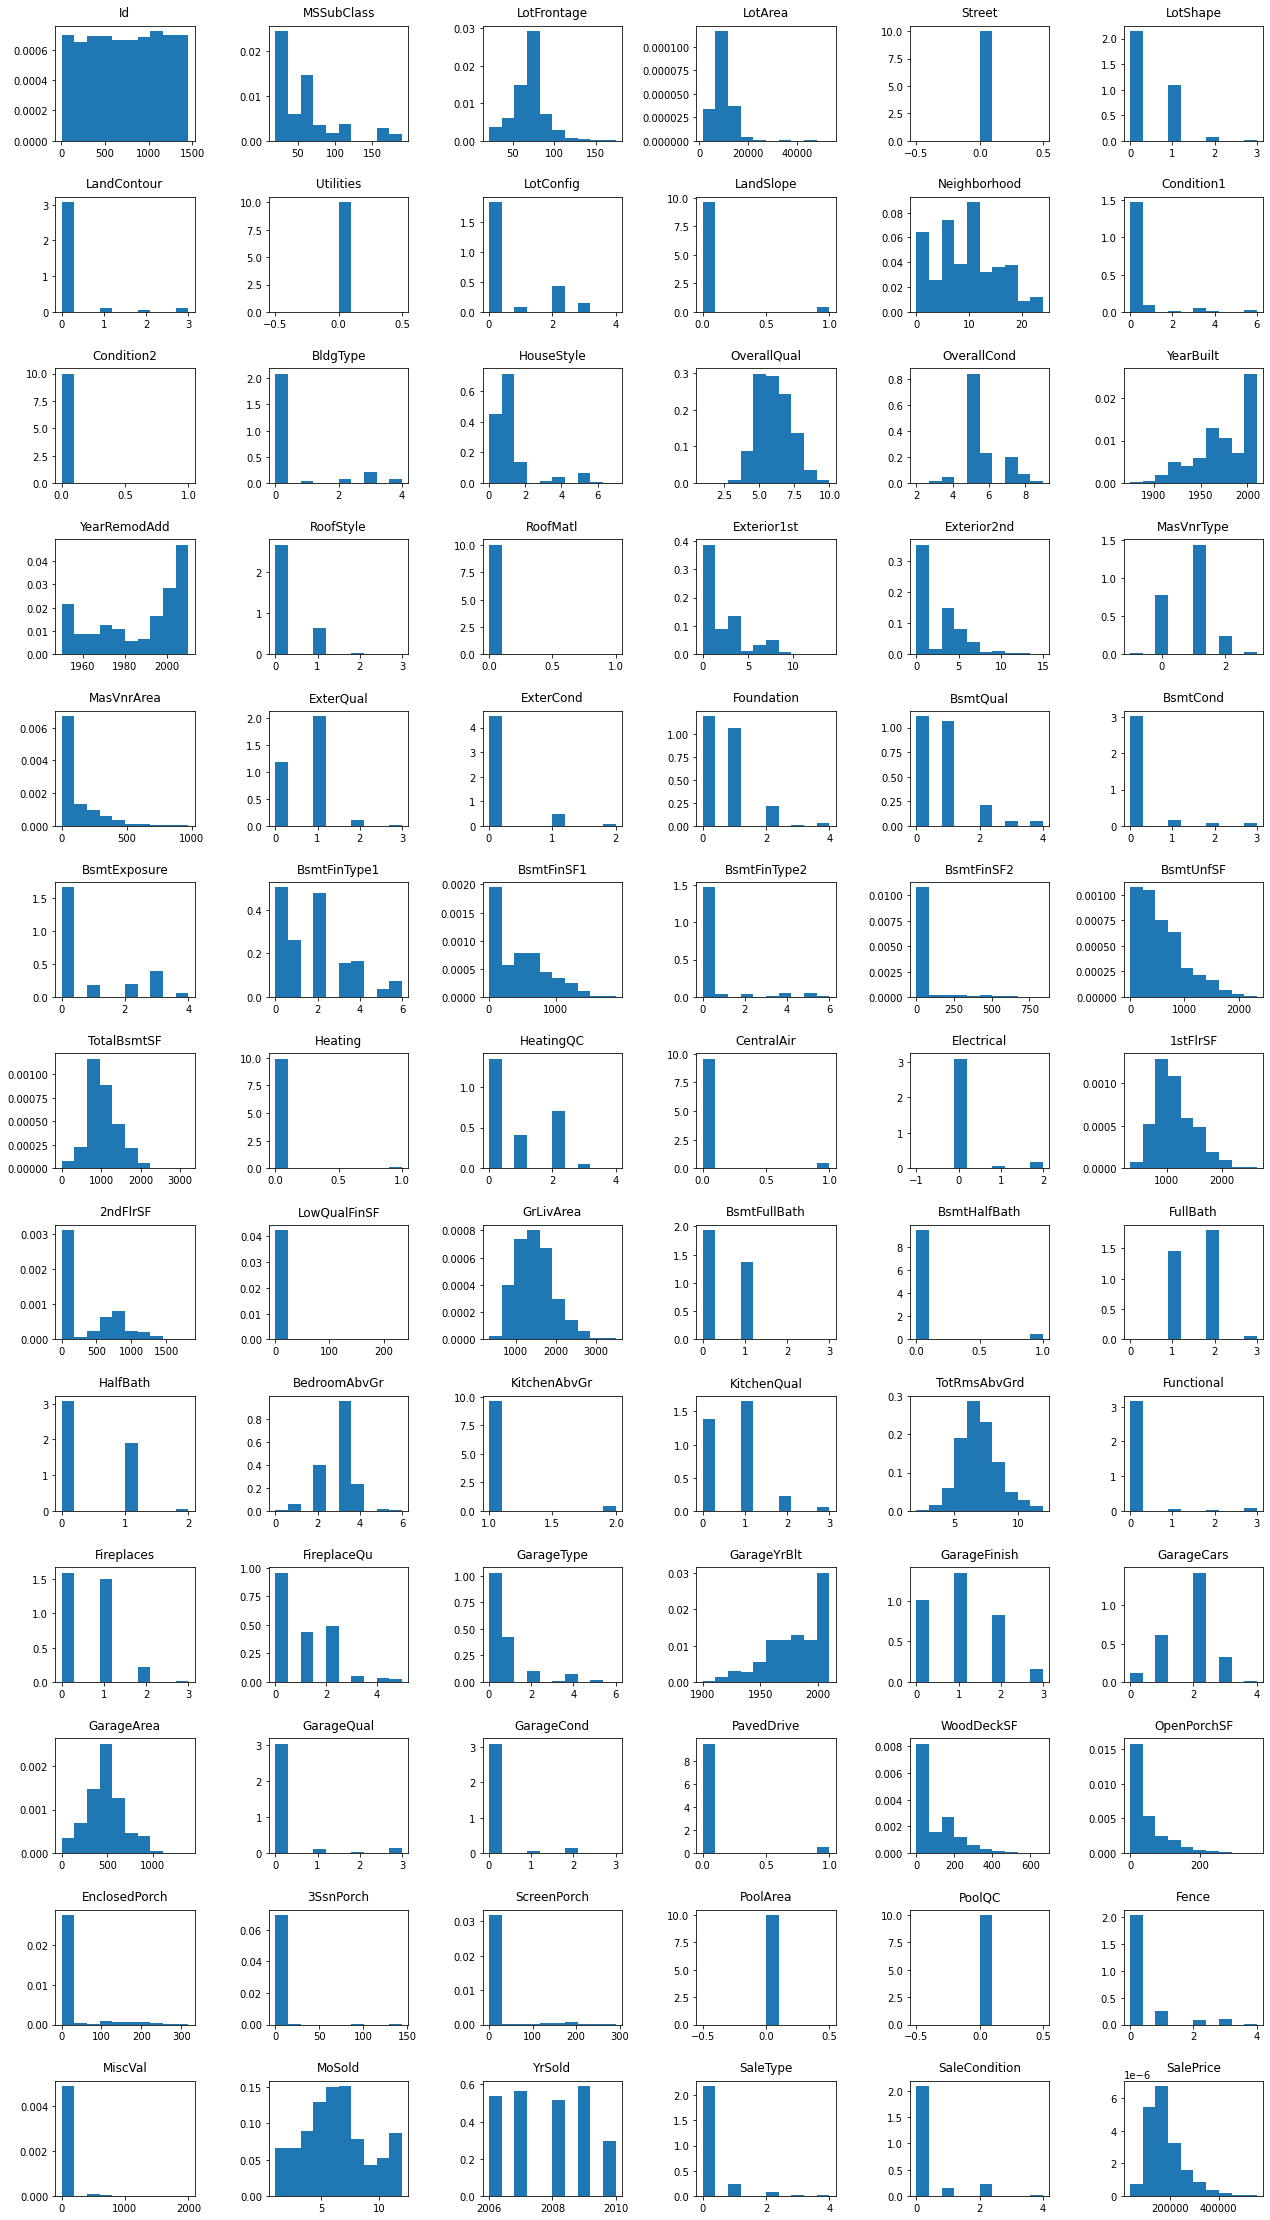

In [84]:
train= clean_df(train_data)
data_dist(train)

(1459, 77) before zscore
(1255, 77) after zscore
Street
Utilities
Condition2
RoofMatl
Heating
LowQualFinSF
3SsnPorch
PoolArea
PoolQC


<ipython-input-83-4054fa8dea82>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_row, n_col, i + 1)


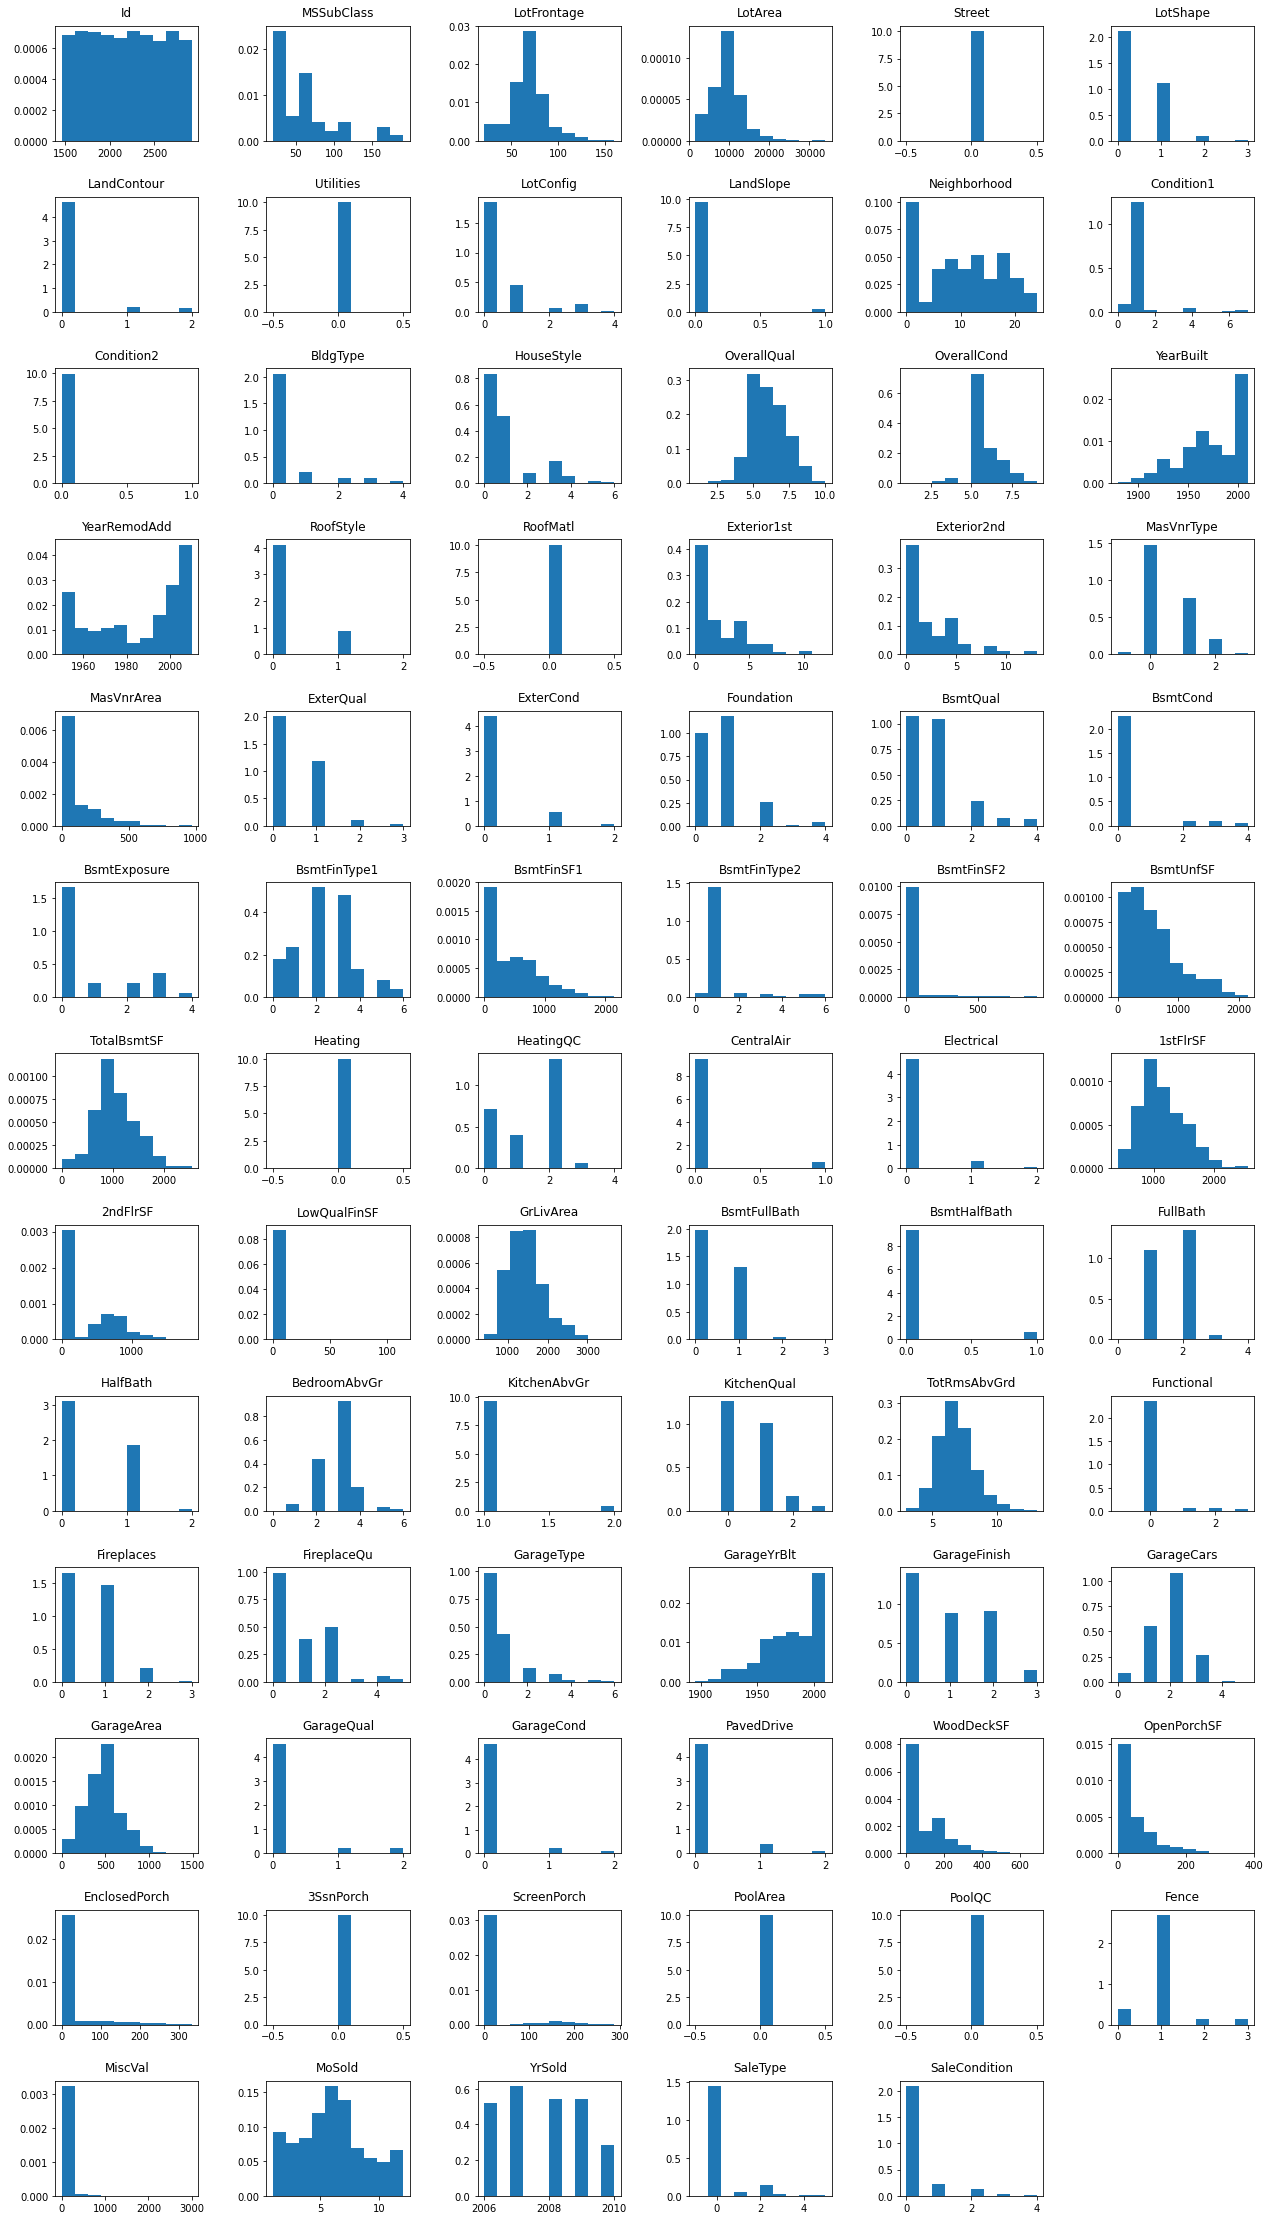

In [85]:
test= clean_df(test_data)
data_dist(test)


In [ ]:
# basically I want to clean outliers and find 
# col; where most samples have the same values